# Домашнее задание. Классификация изображений



Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.




# **МОЙ НИК НА КАГЛ: Elizaveta_Safonova_979932109**

In [ ]:
# we will verify that GPU is enabled for this notebook

# following should print: CUDA is available!  Training on GPU ...

#

# if it prints otherwise, then you need to enable GPU:

# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU



import torch

import numpy as np



train_on_gpu = torch.cuda.is_available()



if not train_on_gpu:

    print('CUDA is not available.  Training on CPU ...')

else:

    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL

print(PIL.__version__)

10.4.0


In [ ]:
!pip install gdown

In [ ]:
#https://drive.google.com/file/d/1c4jOdIC2g_DSP27L6ZIbJnDZ6D_YY7cC/view?usp=sharing
import gdown
# Replace 'FILE_ID' with your actual file ID
file_id = '1c4jOdIC2g_DSP27L6ZIbJnDZ6D_YY7cC'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'your_file.zip', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1c4jOdIC2g_DSP27L6ZIbJnDZ6D_YY7cC
From (redirected): https://drive.google.com/uc?id=1c4jOdIC2g_DSP27L6ZIbJnDZ6D_YY7cC&confirm=t&uuid=544c3503-9d9f-46fe-a11e-2b4dedb256ce
To: /kaggle/working/your_file.zip
100%|██████████| 546M/546M [00:04<00:00, 113MB/s]  


'your_file.zip'

In [ ]:
import zipfile
import os

# Specify the name of your ZIP file
zip_file_path = 'your_file.zip'
extraction_folder = 'extracted_folder'

# Create a directory to extract files if it doesn't exist
os.makedirs(extraction_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)


In [ ]:
cd extracted_folder

/kaggle/working/extracted_folder


In [ ]:
!nvidia-smi

import torch

torch.cuda.is_available()

Sun Nov 17 22:58:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle

import numpy as np

from skimage import io

import pandas as pd



from tqdm import tqdm, tqdm_notebook

from PIL import Image

from pathlib import Path



from torchvision import transforms

from multiprocessing.pool import ThreadPool

from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn

import math



from matplotlib import colors, pyplot as plt

%matplotlib inline



# в sklearn не все гладко, чтобы в colab удобно выводить картинки

# мы будем игнорировать warnings

import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [ ]:
# разные режимы датасета

DATA_MODES = ['train', 'val', 'test']

# все изображения будут масштабированы к размеру 224x224 px

RESCALE_SIZE = 224

# работаем на видеокарте

DEVICE = torch.device("cuda")


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.



ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:

$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet





Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.

 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

**1) добавлена augmentation -- случайные повороты, перспектива, варьирования цвета, инверсия по горизонтали. Датасет остается таким же по размеру: просто во время прохода по эпохам какие-то изображения случайно преобразуются**

**2) добавлен код, добавляющий в тренировочный датасет редких персонажей. Сначала выявляются персонажи, которые появляются меньше 200 раз, затем каждая картинка домножается на соответствующее число, чтобы суммарно было больше 200 появлений каждого персонажа**

In [ ]:
class SimpsonsDataset(Dataset):

    """

    Датасет с картинками, который паралельно подгружает их из папок

    производит скалирование и превращение в торчевые тензоры

    """

    def __init__(self, files, mode):

        super().__init__()

        # список файлов для загрузки

        self.files = sorted(files)

        # режим работы

        self.mode = mode



        if self.mode not in DATA_MODES:

            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")

            raise NameError



        self.label_encoder = LabelEncoder()



        if self.mode != 'test':

            self.labels = [path.parent.name for path in self.files]

            self.label_encoder.fit(self.labels)



            with open('label_encoder.pkl', 'wb') as le_dump_file:

                  pickle.dump(self.label_encoder, le_dump_file)


        if self.mode == "train":

            rare_labels = []

            multiplyer = {}

            min_frequency = 200

            for label in np.unique(self.labels):

                if self.labels.count(label) < min_frequency:

                    rare_labels.append(label)

                    multiplyer.update({f'{label}': math.ceil(min_frequency / self.labels.count(label))})



              #print(f'{label}: {train_labels.count(label)}')



            for index in range(len(self.files)):

              if self.labels[index] in rare_labels:

                self.files.extend([self.files[index]]*multiplyer[self.labels[index]])

                self.labels.extend([self.labels[index]]*multiplyer[self.labels[index]])





        self.len_ = len(self.files)



    def __len__(self):

        return self.len_



    def load_sample(self, file):

        image = Image.open(file)

        image.load()

        return image



    def __getitem__(self, index):

        # для преобразования изображений в тензоры PyTorch и нормализации входа

        transform = transforms.Compose([

            transforms.ToTensor(),

            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        ])

        augmentations = transforms.Compose([

            transforms.ColorJitter(brightness = 0.5, hue = 0.05),

            transforms.RandomPerspective(distortion_scale=0.3, p=0.1, fill = [90,90,90]),

            transforms.RandomHorizontalFlip(p=0.3),

            transforms.RandomRotation(degrees=(-15,15), fill = [90,90,90])])

        x = self.load_sample(self.files[index])



        if self.mode == 'train':

          x = augmentations(x)



        x = self._prepare_sample(x)



        x = transform(x)

        if self.mode == 'test':

            return x

        else:

            label = self.labels[index]

            label_id = self.label_encoder.transform([label])

            y = label_id.item()

            return x, y



    def _prepare_sample(self, image):

        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))

        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    """Imshow для тензоров"""

    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])

    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)

    if title is not None:

        plt_ax.set_title(title)

    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами

TRAIN_DIR = Path('./train/')

TEST_DIR = Path('./testset')

In [ ]:
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split



train_labels = [path.parent.name for path in train_files]


In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')

len(train_dataset)

26012

### Построение нейросети

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score


def fit_epoch(model, train_loader, criterion, optimizer):

    running_loss = 0.0

    running_corrects = 0

    processed_data = 0

    all_preds = []

    all_labels = []



    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)

        labels = labels.to(DEVICE)

        optimizer.zero_grad()



        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        preds = torch.argmax(outputs, 1)

        all_preds.extend(preds.cpu().numpy())

        all_labels.extend(labels.data.cpu().numpy())

        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)

        processed_data += inputs.size(0)



    train_loss = running_loss / processed_data

    train_acc = running_corrects.cpu().numpy() / processed_data

    train_f1 = f1_score(all_labels, all_preds, average='micro')

    train_precison = precision_score(all_labels, all_preds, average='micro')

    train_recall = recall_score(all_labels, all_preds, average='micro')

    return train_loss, train_acc, train_f1, train_precison, train_recall

In [ ]:
def predict(model, test_loader):

    with torch.no_grad():

        logits = []


        for inputs in test_loader:

            inputs = inputs.to(DEVICE)

            model.eval()

            outputs = model(inputs).cpu()

            logits.append(outputs)


    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

**Сначала заморожены все слои модели, кроме последнего nn.Linear. Начиная с 4 эпохи разморожены еще несколько последних слоев**

In [ ]:
def train(train_files, model, epochs, batch_size):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    print(f'train_batch_number = {len(train_loader)}')

    history = []

    log_template = '''\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \

    train_acc {t_acc:0.4f})'''

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        opt = torch.optim.Adam(model.parameters(), lr = 1e-4)

        criterion = nn.CrossEntropyLoss()

        frozen_layers = [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool]

        for layer in frozen_layers:
                    for param in layer.parameters():
                        param.requires_grad = False

        for epoch in range(epochs):

            if epoch > 3:

                for param in model.layer3.parameters():

                    param.requires_grad = True

                for param in model.layer4.parameters():

                    param.requires_grad = True

                for param in model.avgpool.parameters():

                    param.requires_grad = True




            train_loss, train_acc, train_f1, train_precision, train_recall = fit_epoch(model, train_loader, criterion, opt)

            print("loss", train_loss)

            history.append((train_loss, train_acc, train_f1))



            pbar_outer.update(1)

            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\

                                        t_acc=train_acc))

            print(f'Train f1 {train_f1}')


    return history

**В качестве одели взята ResNet50. Последний слой изменен, чтобы он выдавал нужное количество классов на выходе**

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

n_classes = len(np.unique(train_labels))

#weights=ResNet18_Weights.IMAGENET1K_V1

ResNet50 = resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)

ResNet50.fc = nn.Linear(in_features=2048, out_features=n_classes, bias=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s] 


Запустим обучение сети.

In [ ]:
my_model = ResNet50.to(DEVICE)

In [ ]:
history = train(train_dataset, model=my_model, epochs=15, batch_size=256)

train_batch_number = 102


epoch:   7%|▋         | 1/15 [03:35<50:22, 215.90s/it]

loss 3.3596248754662366

Epoch 001 train_loss: 3.3596     
    train_acc 0.1119)
Train f1 0.11194833153928956


epoch:  13%|█▎        | 2/15 [07:07<46:16, 213.58s/it]

loss 3.004049438413209

Epoch 002 train_loss: 3.0040     
    train_acc 0.2796)
Train f1 0.2795632784868522


epoch:  20%|██        | 3/15 [10:40<42:35, 212.99s/it]

loss 2.7240741396250954

Epoch 003 train_loss: 2.7241     
    train_acc 0.3764)
Train f1 0.3763647547285868


epoch:  27%|██▋       | 4/15 [14:13<39:06, 213.27s/it]

loss 2.4871417279062356

Epoch 004 train_loss: 2.4871     
    train_acc 0.4363)
Train f1 0.4363370751960634


epoch:  33%|███▎      | 5/15 [18:01<36:26, 218.63s/it]

loss 0.5152214382513476

Epoch 005 train_loss: 0.5152     
    train_acc 0.8901)
Train f1 0.8901276333999693


epoch:  40%|████      | 6/15 [21:53<33:26, 222.98s/it]

loss 0.08413921021395934

Epoch 006 train_loss: 0.0841     
    train_acc 0.9832)
Train f1 0.9832385053052437


epoch:  47%|████▋     | 7/15 [25:41<29:56, 224.56s/it]

loss 0.044898852355366906

Epoch 007 train_loss: 0.0449     
    train_acc 0.9905)
Train f1 0.9905043825926495


epoch:  53%|█████▎    | 8/15 [29:29<26:19, 225.66s/it]

loss 0.030180708004679292

Epoch 008 train_loss: 0.0302     
    train_acc 0.9938)
Train f1 0.9937721051822236


epoch:  60%|██████    | 9/15 [33:16<22:37, 226.20s/it]

loss 0.023775207709352635

Epoch 009 train_loss: 0.0238     
    train_acc 0.9953)
Train f1 0.9953098569890819


epoch:  67%|██████▋   | 10/15 [37:04<18:53, 226.77s/it]

loss 0.019640899793644896

Epoch 010 train_loss: 0.0196     
    train_acc 0.9955)
Train f1 0.9954636321697679


epoch:  73%|███████▎  | 11/15 [40:53<15:09, 227.34s/it]

loss 0.012603396794717349

Epoch 011 train_loss: 0.0126     
    train_acc 0.9976)
Train f1 0.9975780409041981


epoch:  80%|████████  | 12/15 [44:43<11:24, 228.16s/it]

loss 0.01143939540365302

Epoch 012 train_loss: 0.0114     
    train_acc 0.9976)
Train f1 0.9975780409041981


epoch:  87%|████████▋ | 13/15 [48:33<07:37, 228.82s/it]

loss 0.011756347406766685

Epoch 013 train_loss: 0.0118     
    train_acc 0.9969)
Train f1 0.9968860525911118


epoch:  93%|█████████▎| 14/15 [52:21<03:48, 228.66s/it]

loss 0.008683347530412675

Epoch 014 train_loss: 0.0087     
    train_acc 0.9983)
Train f1 0.9983469168076272


epoch: 100%|██████████| 15/15 [56:11<00:00, 224.74s/it]

loss 0.009230544834055308

Epoch 015 train_loss: 0.0092     
    train_acc 0.9977)
Train f1 0.9977318160848839


Построим кривые обучения

In [ ]:
loss, acc, f1 = zip(*history)

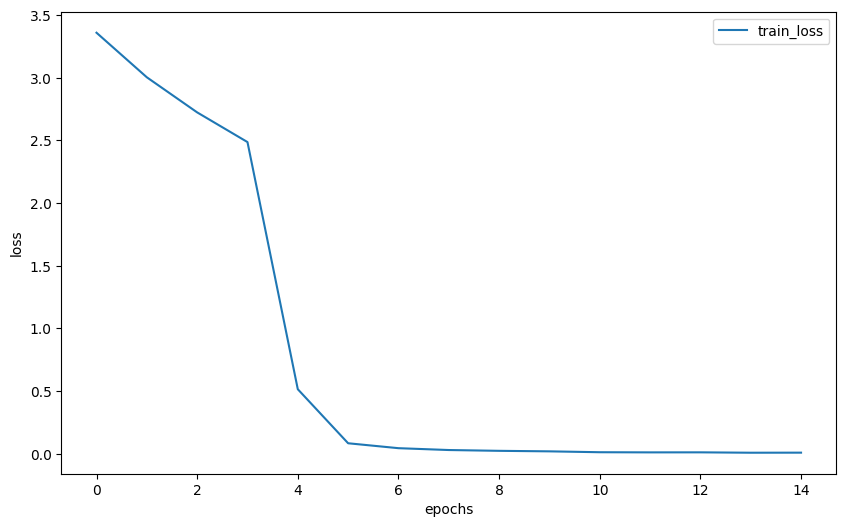

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(loss, label="train_loss")

plt.legend(loc='best')

plt.xlabel("epochs")

plt.ylabel("loss")

plt.show()

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

probs = predict(my_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

characters_illustration.png  sample_submission.csv  train
label_encoder.pkl	     testset


In [ ]:
import pandas as pd

my_submit = pd.read_csv("sample_submission.csv")

# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})

my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('submisson.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
ls

characters_illustration.png  sample_submission.csv  testset/
label_encoder.pkl            submisson.csv          train/
